# Import stuff

In [0]:
import sys

import grading
import download_utils

In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
import grading_utils
#import keras_utils
#from keras_utils import reset_tf_session

1.15.2
2.3.1


Using TensorFlow backend.


# Load dataset

In [0]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [0]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

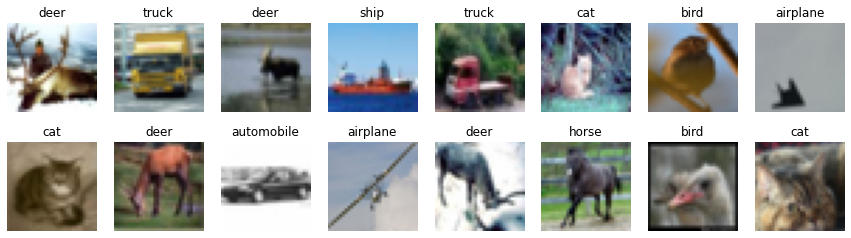

In [0]:
# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Prepare data

In [0]:
# normalize inputs
x_train2 = x_train/255.0 - 0.5
x_test2 = x_test/255.0 - 0.5

from keras.utils import to_categorical
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = to_categorical(y_train, num_classes=10, dtype='float32')
y_test2 = to_categorical(y_test,num_classes=10,dtype='float32')

In [0]:
y_test2[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

# Define CNN architecture

In [0]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

In [0]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = (3,3), strides=1, padding='same' ,input_shape=(32, 32, 3)))
    model.add(Activation(LeakyReLU(0.1)))
    model.add(Conv2D(filters = 32, kernel_size = (3,3), strides=1, padding='same')) 
    model.add(Activation(LeakyReLU(0.1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 32, kernel_size = (3,3), strides=1, padding='same' ))
    model.add(Activation(LeakyReLU(0.1)))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), strides=1, padding='same')) 
    model.add(Activation(LeakyReLU(0.1)))
    model.add(MaxPooling2D(pool_size=(2, 2) ))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation(LeakyReLU(0.1)))
    model.add(Dropout(0.5))
    model.add(Dense( 10))
    model.add(Activation("softmax"))
    return model

In [0]:
# describe model
s = tf.reset_default_graph()  # clear default graph
model = make_model()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
______________________________________

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [0]:
## GRADED PART, DO NOT CHANGE!
# Number of model parameters
grader.set_answer("7W4tu", grading_utils.model_total_params(model))

In [0]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# Train model

In [0]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

s = tf.reset_default_graph()# clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [0]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = 'cifar.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
#from keras.models import load_model
#s = tf.reset_default_graph()
#last_finished_epoch = 7
#model = load_model(model_filename.format(last_finished_epoch))

In [0]:
# fit model
model.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), 
               LrHistory(), 
               keras.callbacks.History()],
    validation_data=(x_test2, y_test2),
    shuffle=True
)


Train on 50000 samples, validate on 10000 samples
Epoch 1/10
Learning rate: 0.005
50000/50000 [==============================] - 15s 296us/step - loss: 1.3420 - accuracy: 0.5180 - val_loss: 0.9977 - val_accuracy: 0.6438
Epoch 2/10
Learning rate: 0.0045
50000/50000 [==============================] - 13s 257us/step - loss: 0.9471 - accuracy: 0.6692 - val_loss: 0.8381 - val_accuracy: 0.7076
Epoch 3/10
Learning rate: 0.00405
50000/50000 [==============================] - 13s 256us/step - loss: 0.8061 - accuracy: 0.7188 - val_loss: 0.7185 - val_accuracy: 0.7514
Epoch 4/10
Learning rate: 0.003645
50000/50000 [==============================] - 13s 256us/step - loss: 0.7219 - accuracy: 0.7452 - val_loss: 0.7032 - val_accuracy: 0.7580
Epoch 5/10
Learning rate: 0.0032805
50000/50000 [==============================] - 13s 259us/step - loss: 0.6582 - accuracy: 0.7709 - val_loss: 0.6418 - val_accuracy: 0.7773
Epoch 6/10
Learning rate: 0.00295245
50000/50000 [==============================] - 13s 2

In [0]:
# save weights to file
model.save_weights("weights.h5")

In [0]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

# Evaluate model

In [0]:
# make test predictions
y_pred_test = model.predict_proba(x_test2)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

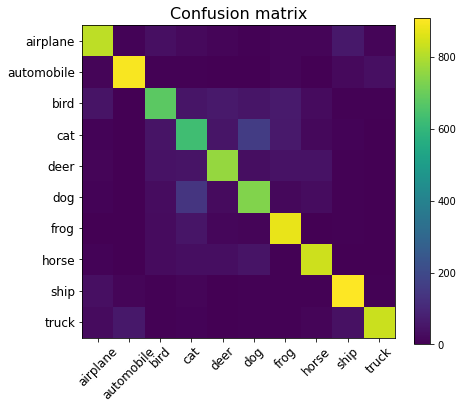

Test accuracy: 0.7996


In [0]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

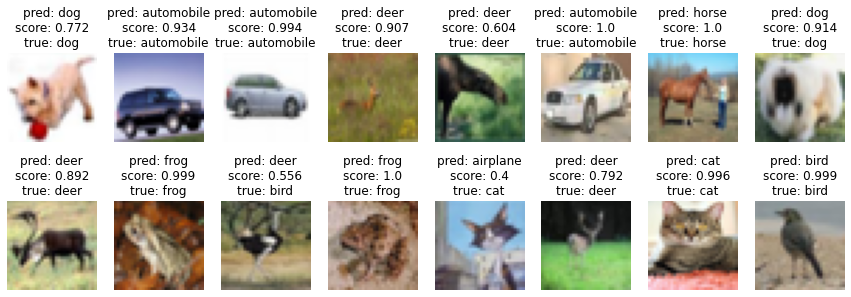

In [0]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Visualize maximum stimuli

++.............................We want to find input images that provide maximum activations for particular layers of our network. 

We will find those maximum stimuli via gradient ascent in image space.

For that task we load our model weights, calculate the layer output gradient with respect to image input and shift input image in that direction.

In [0]:
s = tf.reset_default_graph()  # clear default graph
K.set_learning_phase(0)  # disable dropout
model = make_model()
model.load_weights("weights.h5")  # that were saved after model.fit

/usr/local/lib/python3.6/dist-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [0]:
# all weights we have
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)       

In [0]:
def find_maximum_stimuli(layer_name, is_conv, filter_index, model, iterations=20, step=1., verbose=True):
    
    def image_values_to_rgb(x):
        # normalize x: center on 0 (np.mean(x_train2)), ensure std is 0.25 (np.std(x_train2))
        # so that it looks like a normalized image input for our network
        x_norm = (x-np.mean(x_train2))/np.std(x_train2)

        # do reverse normalization to RGB values: x = (x_norm + 0.5) * 255
        x = (x_norm+0.5)*255
    
        # clip values to [0, 255] and convert to bytes
        x = np.clip(x, 0, 255).astype('uint8')
        return x

    # this is the placeholder for the input image
    input_img = model.input
    img_width, img_height = input_img.shape.as_list()[1:3]
    
    # find the layer output by name
    layer_output = list(filter(lambda x: x.name == layer_name, model.layers))[0].output

    # we build a loss function that maximizes the activation
    # of the filter_index filter of the layer considered
    if is_conv:
        # mean over feature map values for convolutional layer
        loss = K.mean(layer_output[:, :, :, filter_index])
    else:
        loss = K.mean(layer_output[:, filter_index])

    # we compute the gradient of the loss wrt input image
    grads = K.gradients(loss, input_img)[0]  # [0] because of the batch dimension!

    # normalization trick: we normalize the gradient
    grads = grads / (K.sqrt(K.sum(K.square(grads))) + 1e-10)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # we start from a gray image with some random noise
    input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * (0.1 if is_conv else 0.001)

    # we run gradient ascent
    for i in range(iterations):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        if verbose:
            print('Current loss value:', loss_value)

    # decode the resulting input image
    img = image_values_to_rgb(input_img_data[0])
    
    return img, loss_value

In [0]:
# sample maximum stimuli
def plot_filters_stimuli(layer_name, is_conv, model, iterations=20, step=1., verbose=False):
    cols = 8
    rows = 2
    filter_index = 0
    max_filter_index = list(filter(lambda x: x.name == layer_name, model.layers))[0].output.shape.as_list()[-1] - 1
    fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
    for i in range(cols):
        for j in range(rows):
            if filter_index <= max_filter_index:
                ax = fig.add_subplot(rows, cols, i * rows + j + 1)
                ax.grid('off')
                ax.axis('off')
                loss = -1e20
                while loss < 0 and filter_index <= max_filter_index:
                    stimuli, loss = find_maximum_stimuli(layer_name, is_conv, filter_index, model,
                                                         iterations, step, verbose=verbose)
                    filter_index += 1
                if loss > 0:
                    ax.imshow(stimuli)
                    ax.set_title("Filter #{}".format(filter_index))
    plt.show()

In [0]:
# maximum stimuli for convolutional neurons
conv_activation_layers = []
for layer in model.layers:
    if isinstance(layer, LeakyReLU):
        prev_layer = layer.inbound_nodes[0].inbound_layers[0]
        if isinstance(prev_layer, Conv2D):
            conv_activation_layers.append(layer)

for layer in conv_activation_layers:
    print(layer.name)
    plot_filters_stimuli(layer_name=layer.name, is_conv=True, model=model)

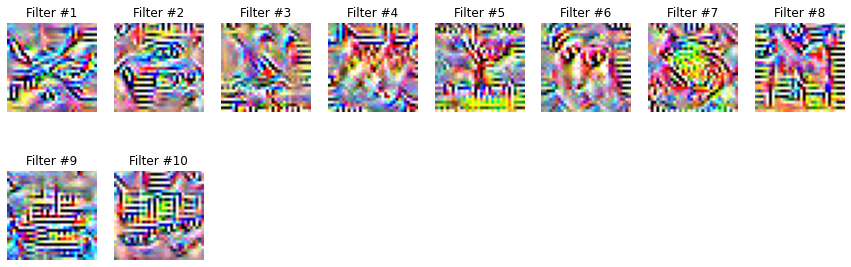

In [0]:
# maximum stimuli for last dense layer
last_dense_layer = list(filter(lambda x: isinstance(x, Dense), model.layers))[-1]
plot_filters_stimuli(layer_name=last_dense_layer.name, is_conv=False, 
                     iterations=200, step=0.1, model=model)

In [0]:
def maximum_stimuli_test_for_grader():
    layer = list(filter(lambda x: isinstance(x, Dense), model.layers))[-1]
    output_index = 7
    stimuli, loss = find_maximum_stimuli(
        layer_name=layer.name, 
        is_conv=False, 
        filter_index=output_index,
        model=model,
        verbose=False
    )
    return model.predict_proba(stimuli[np.newaxis, :])[0, output_index]